Rappels

[GO ontology](https://www.ebi.ac.uk/QuickGO/)

##### IFB Virtual Machine Configuration

* `rootDir` points to Jupyter Home Directory
* `projectDir` points to the Git project, holds the *tsv* file
* `libDir` points to Git project python library with files names `go.py  stat_utils.py  uniprot.py`
* `dataDir` points to shared data folder with uniprot and GO files

In [3]:
import sys

rootDir = "//ifb/data/mydatalocal"
projectDir = rootDir + "/VDBscratch"
libDir = projectDir + "/lib"
dataDir= "/ifb/data/public/teachdata/m2binf_ucbl/data" 

sys.path.append(libDir)

In [4]:
import pandas, uniprot, go
import numpy as np
from stat_utils import computeORA_BKG

%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib nbagg
import matplotlib.pyplot as plt

## Jeux de données
* Experimental dataset as TSV
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files

## Objectifs
1. Lire et traiter des données d'entrée avec [PANDAS](https://pandas.pydata.org/)

2. Représenter la distribution empirique des "fold-change" (**FC**)

3. Evaluer un seuil de **FDR** 5%, with normal approximation
    1. Proposer une function qui à un seuil de faux-positif retourne une valeur de **FDC**
    2. Proposer une fonction qui appelle la précedente et retourne, en plus, une représentation graphique

4. Analyse de l'enrichissement en pathway Gene Ontology
    1. Arbre des termes d'ontologie.
        * Visualisation de l'arbre complet
    2. Modélisation hypergéometrique des fréquence attendues des termes GO
        * Les protéines très abondantes présentent-elles des termes GO en quantité remarquable ?
        * Les protéines peu abondantes présentent-elles des termes GO en quantité remarquable ?
    3. Visualisation de l'arbre avec style des noeuds rendant compte des protéines qu'ils annotent
 
5. Volcano plot
    1. Scatter-Plot **FC** vs **LOG10 Adj.P-val**
    2. Colorer les protéines très/peu abondantes
    3. ipyWidget slider FDR permettant de changer les seuils "d'abondance" 
    
6. Volcano Plot présentant les pathways
    1. ipyWidget Slider
    2. Coloration des points pour les protéines annotées par ce pathway 

## Conclusion
* Compare wt/mutant conditions


## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

https://matplotlib.org/gallery.html#




## Format des données expérimentales

Le terme *SA*, désigne le ratio de (**S**ur) **A**bondance pour une protéines entre deux experiences.
Les valeurs de **SA** sont stockées dans la colonne ```Log2 Corrected Abundance Ratio```. Un "ratio" négatif indique qu'une protéine est moins présente dans l'experience considéré par rapport à une experience de référence.

* La condition experimentale de référence est un milieu de croissance bactérienne
* La condition experimentale testée est un milieu riche en Tétracycline 



# Première exploration des données

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques
* Créer une DataFrame ne contenant que les lignes où **Log2 Corrected Abundance Ratio** > 0

##### [Comment filtrer des lignes Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/)

In [6]:
import pandas
df=pandas.read_csv(projectDir + "/TCL_wt1.tsv", delimiter ="\t")
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721334942,0.000055,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429568818,0.000351,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695189,0.000027,4.571899347
3,P0CE48,Elongation factor Tu 2 OS=Escherichia coli (st...,tufB,#VALEUR!,#VALEUR!,NaN,#VALEUR!
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204276506,0.019963,1.699767669


In [10]:
dfClean = df[ (df['Log2 Corrected Abundance Ratio'] != '#VALEUR!') & (df['LOG10 Adj.P-val'] != '#VALEUR!')]
dfClean = dfClean.copy()
dfClean.loc[:,'Log2 Corrected Abundance Ratio'] = dfClean.loc[:,'Log2 Corrected Abundance Ratio'].astype(float)

saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()

dfClean.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075816993,-3.721335,0.000055,4.260067469
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810458,-3.429569,0.000351,3.45462743
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614379,-3.284695,0.000027,4.571899347
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108496732,-3.204277,0.019963,1.699767669
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183007,-3.009460,0.036746,1.434786589


### Rappel
Pour faciliter le développement nous considerereons comme **S**ur**A**bondante toute protéine à **Log2 Corrected Abundance Ratio** supérieur à 0.

# Definitions de pathway fonctionels: modèle statisitique

Nous disposons d'un jeu de protéines caractérisées par

* Un ratio de quantification entre deux experiences
* Une fiche uniprot 

Par ailleurs, l'ontologie GO est disponible via
* un fichier plat de définition
* une librarie pour la manipuler

Il nous est demandé de detecter si certains termes GO sont fortement représentés parmi les protéines SurAbondantes.
Par la suite, on utilisera indifférement les termes **Pathway** et **annotation GO**.

### Evaluation théorique de l'abondance

* $Q+$ : Proteines Sur-représentées
* $\overline{Q+}$ : Proteines non Sur-représentées

* $PW^{a}$ : Nombre de protéines membres du Pathway$a$
* $\overline{PW^{a}}$ : Nombre de protéines non-membres du Pathway$a$



 Proteines | $Q+$  | $\overline{Q+}$ | Total lignes
 :--- | --- |--- |---|
membres de $PW^{a}$  | $PW^{a}_{Q+}$ | $PW^{a}_{\overline{Q+}}$ | $nPW^{a}$
non-membres de $PW_{a}$ | $\overline{PW^{a}}_{Q+}$ | $\overline{PW^{a}}_{\overline{Q+}}$ | $n\overline{PW^{a}}$
  **Total colonnes** | n$Q+$ | n$\overline{Q+}$ | **nTOT**
 
 
**Question**:"Le nombre de protéines sur-représentées dans le Pathway$a$ est-il grand comparé à ce qui serait attendu au hasard?"


<!--## Deprecated 
 **Question**:"Les protéines sur-représentées sont-elles plus fréquentes dans le Pathway$a$ que dans les protéines non-membre du Pathway$X$?"
 
L'hypothèse nulle est "Les protéines membres du pathway et non-membres du pathway ont des quantifications similaires".
 -->
        

### Modélisation du hasard par une loi hypergéométrique

Pour un pathway donné ($PWa$), chaque protéine sur-abondante peut être vue comme un tirage dans le pool de protéines de l'expérience. La population de ce pool est consituée de deux groupes:
 * Le groupe des protéines appartenant à $PWa$
 * Les autres ($\overline{PW^{a}}$)

La probabilité d'observer $k$ protéines de $PWa$ parmi les $n$ sur-abondantes se modélise alors naturellement par la loi de probabilité hypergéométrique.

Rappellez-vous,

Si X est la variable aléatoire du nombre de succès parmi n observations, sans remise.
Alors la probabilité d'oberver exactement $k$ succès, suit une loi hypergéométrique de paramètres $N, n$ et $k$

$P(X=k) = \frac{ {K\choose k} {N-K\choose n-k} } { {N\choose K} }$

où


* $K$ est le nombre de succès dans la population totale
* $n$ est le nombre d'observations
* $N$ est la taille de la population totale
* $k$ est le nombre de succès parmi les observations

Si **pour chaque $Pathway^{a}$**, $X$ est la variable aléatoire du **nombre de protéines sur-représentée** dans l'experience.


Cocher les relations correspondantes


  x  | $nTOT$ | $nPW^{a}_{Q+}$ | $nPW^{a}$ | $nQ+$
 --- | ---   | ---     | ---  | --- |
 $K$ |       |         |      | 
 $n$ |       |         |      | 
 $N$ |       |         |      | 
 $k$ |       |         |      | 
 
 
 
 
Rappel: $nPW^{a}_{Q+}$ est le nombre de protéines appartenant au $Pathway^{a}$ parmi les protéines surexprimées

Que représentent alors les deux expressions suivantes:

$ P(X=nPW^{a}_{Q+})= \frac{ {nPW^{a}\choose X} {n\overline{PW^{a}}\choose nQ^{+} - X} } { {nTOT\choose nPW^{a}} }$


$P(X >= PW^{a}_{Q+})  = \sum_{x_{i}=PW^{a}_{Q+}}^{x_{i} \le nQ+}\frac{ {nPW^{a}\choose x_{i}} {n\overline{PW^{a}}\choose nQ^{+} - x_{i}} } { {nTOT\choose nPW^{a}} }$


###### Créer la fonction qui retournera la probabilité, sous un [modèle hypergeométrique](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.hypergeom.html), d'obtenir $k$ succès ou plus,

```python
def righEnd_pValue(N, n, K, k) => p
```
Aux arguments:
* $N$, le nombre total d'objet
* $n$, le nombre de tirages
* $K$, le nombre total d'objet de *typeI*
* $k$, le nombre de tirage d'objet de *typeI* (ie: nombre de succès parmi les tirages)

##### Dessiner les lollipop charts de la densité de probabilité et de la densité cumulée de la loi

L'enrichissement en terme GO parmi les protéines surabondantes sera estimé par cette fonction, avec
* $N$, le nombre total de protéines annotées dans le protéome
* $n$, le nombre de protéines surabondantes
* $K$, le nombre de protéines annotées par ce terme GO dans le protéome
* $k$, le nombre de protéines annotées par ce terme GO dans les protéines surabondantes


0.9999999833384777

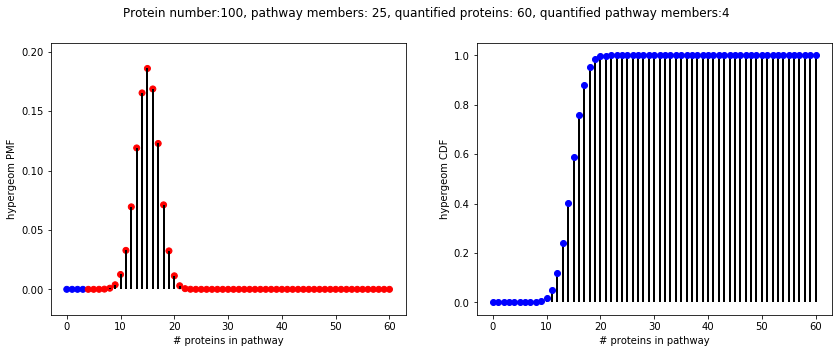

In [31]:
from scipy.stats import hypergeom
%matplotlib inline
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()

def righEnd_pValue(N, n, K, k):
    
    rv = hypergeom(N, K, n)
    x = np.arange(0, n+1)
    pmf_pathway_members = rv.pmf(x)
    cmf_pathway_members = rv.cdf(x)
    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot(121)
    ax.scatter(x, pmf_pathway_members, color = [ 'b' if _x < k else 'r' for _x in x ])
    ax.vlines(x, 0, pmf_pathway_members, lw=2)
    ax.set_xlabel('# proteins in pathway')
    ax.set_ylabel('hypergeom PMF')
    
    ax = fig.add_subplot(122)
    ax.plot(x, cmf_pathway_members, 'bo')
    ax.vlines(x, 0, cmf_pathway_members, lw=2)
    ax.set_xlabel('# proteins in pathway')
    ax.set_ylabel('hypergeom CDF')
    
    fig.suptitle(f"Protein number:{N}, pathway members: {K}, quantified proteins: {n}, quantified pathway members:{k} ")
    
    p_x = hypergeom(N, K, n).cdf([k - 1])
    return 1.00 - p_x[0]

righEnd_pValue(100, 60, 25, 4)

# Definitions de pathway fonctionels: manipulation de l'ontologie


##### Chargement des données uniprot et GO

In [13]:
uniprotCollection = uniprot.UniprotCollection(dataDir +"/dataset")
K12 = uniprot.UniprotCollection(dataDir + "/K12_proteome/")
print("Loading ontology")
go.setOntology(dataDir + "/go.owl")

Loading ontology
Loaded


In [14]:
xpProtList = dfClean['Accession'].tolist()

print("Extracting biological process ontology")
xpGoTree_BP = go.AnnotationTree("biological process", collapse=True)
xpGoTree_BP.extract(xpProtList, uniprotCollection)

fullEcoliGoTree_BP = go.AnnotationTree("biological process", collapse=True)
fullEcoliGoTree_BP.extract(K12.list, K12)
# check that :: 2728 leaves, 6650 nodes, 3128 proteins
print("Extracting molecular function ontology")
xpGoTree_MF = go.AnnotationTree("molecular function", collapse=True)
xpGoTree_MF.extract(xpProtList, uniprotCollection)

fullEcoliGoTree_MF = go.AnnotationTree("molecular function", collapse=True)
fullEcoliGoTree_MF.extract(K12.list, K12)

print("Extracting cellular component ontology")
xpGoTree_CC = go.AnnotationTree("cellular component", collapse=True)
xpGoTree_CC.extract(xpProtList, uniprotCollection)

fullEcoliGoTree_CC = go.AnnotationTree("cellular component", collapse=True)
fullEcoliGoTree_CC.extract(K12.list, K12)

Extracting biological process ontology
Applying true path collapsing
2194 leaves, 3482 nodes, 1474 proteins
Applying true path collapsing
2728 leaves, 6650 nodes, 3128 proteins
Extracting molecular function ontology
Applying true path collapsing
1694 leaves, 4328 nodes, 1517 proteins
Applying true path collapsing
2264 leaves, 7807 nodes, 3118 proteins
Extracting cellular component ontology
Applying true path collapsing
209 leaves, 2324 nodes, 1426 proteins
Applying true path collapsing
239 leaves, 4698 nodes, 2805 proteins


## Manipulation de termes GO à l'aide de *go.py*

Règle du vrai chemin: *Si une protéine est porteuse d'un terme GO, alors est elle aussi porteuse de tous les parents de ce terme.*

### AnnotationTree est l'arbre des annotations GO portées par une collection de proteines 

#### Un arbre ne rend compte que d'un seul namespace GO
On définit le namespaced des termes GO à extraire par un de ces trois termes : 
* "biological process", "molecular function", "cellular component"
 
```python
aTree = go.AnnotationTree("biological process", collapse=True)
```
On ne garde dans cet arbre que les termes portés par les protéines données en dernier argument
```python
aTree.read_DAG(['P75936', 'P76231', 'P0A8S9'], uniprotCollection)
```

### API de l'arbre d'annotations


#### Taille de l'abre
```python
aTree.dimensions
```

#### Extraire un sous arbre
```python
bTree = aTree.newRoot("transmembrane transport")
```

#### Enumerer les protéines porteuses de termes GO

##### Dans tout l'arbre
```python
proteinList = aTree.getMembers()
```
##### A partir d'un noeud
```python
proteinList = aTree.getMembersByName("transmembrane transport")
proteinList = aTree.getMembersByID("GO:0055085")
```

#### Acceder directement à un noeud
```python
goTerm = aTree.getByName("transmembrane transport")
goTerm = aTree.getByID("GO:0055085")
```

#### Elager un arbre
Retirer tous les noeuds n'ayant aucun des éléments suivants parmi leurs protéines annotées

```python
def predicat(goTerm):
    return set(goTerm.getMembers()) & set(['P75936', 'P76231', 'P0A8S9'])

bTree = aTree.drop(predicat)
```

## Evaluer la pValue d'enrichissment en terme GO d'une liste de protéine donnée

Avant d'appeler `righEnd_pValue`, on devra donc

1. Lister les protéines surabondantes
2. Lister toutes les protéines sous le terme GO de votre choix 
    1. dans l'experience
    2. dans le protéome
3. Calculer l'intersection entre *A* et *B*

###### *Aide:*
Vous vous aiderez 
- de l'API de `go.annotationTree` 
- des commandes [`set` de python](https://docs.python.org/3/library/stdtypes.html#set)
- du [filtrage de colonne Pandas](https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/) pour évaluer la liste de protéines surabondantes
- de la [fonction subplot de matplotlib](https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python), pour dessiner les deux courbes cote-à-cote


## Analyse de la surreprésentation

Le package *stat_utils.py* permet d'appliquer L'analyse de surreprésentation récursivement, en profondeur, à partir d'un terme GO racine.

#### Estimation récursive des enrichissements

* Choix du terme GO général
```python
pathWayRoot = xpGoTree.getByName("transmembrane transport")
```

* Définition du terme GO regroupant tout le protéome
```python
pathWayBKG = fullEcoliGoTree.getByName("biological process")
```

* Calcul de l'enrichissement en termes GO successifs parmi les protéines surabondantes (ici, *saList*)
```python
oraFisher, oraCDF = computeORA_BKG(pathWayRoot, saList, pathWayBKG)
```
* Des arbres peuvent également être passés.
```python
tm_transport_GoTree = xpGoTree.newRoot("transmembrane transport")
oraFisher, oraCDF = computeORA_BKG(tm_transport_GoTree, saList, fullEcoliGoTree)
```

#### Affichage des enrichissements
La fonction ci-dessous va vous permettre d'afficher les pathway par ordre croissant de p-value
```python
def printRankings(saList,_oraFisher, _oraCDF):
    fisherRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraFisher, key=lambda x:x[0]) ]
    cdfRanking = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(saList) ), len(saList) ) for d in sorted(oraCDF, key=lambda x:x[0]) ]
    print(f"FISHER test Rankings:\n{fisherRanking}")
    print('\n---\n')
    print(f"CDF Rankings:\n{cdfRanking}")
```

##### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, proposer une classe `Rankings` implémentant une méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) qui permette un affichage plus lisible des résultats, comme par exemple:

![caption](../figs/_repr_html_.png)

#### Appliquer cette analyse à terme GO de votre choix (et tous ses fils)
 - Il serait souhaitable d'encapsuler les différentes étapes dans une fonction de ce type
```python
    def computePathway(goTermString, xpTreeTerm, bkgTreeTerm, uniprotIdList) -> oraFisher, oraCDF
```
#### Appliquer cette analyse à tous les termes GO des arbres "biological process", "molecular function", "cellular component"

***


##### STEP by STEP solution

In [78]:
pathWaySetRoot    = xpGoTree_BP.getByName("transmembrane transport")
pathWaySetRootBKG = fullEcoliGoTree_BP.getByName("biological process")

In [79]:
class Rankings():
    def __init__(self, oraResults, proteinList, title="Pathway ORA"):
        self.title = title
        self.ranks = [ ( d[0], d[1].name, len( set(d[1].getMembers()) & set(proteinList) ), len(proteinList) ) for d in sorted(oraResults, key=lambda x:x[0]) ]
    def _repr_html_(self):
        t_head = f"<h3>{self.title}</h3><table><thead><th>p-value</th><th>Pathway name</th><th>n</th></thead><tbody>"
        t_foot = '</tbody></table>'
        t_body = '</tr><tr>'.join([ '<td>' + '</td><td>'.join([ str(v) for v in pathwayScore ][:-1]) + '</td>' for pathwayScore in self.ranks ])
        t_body = '<tr>' + t_body + '</tr>'
        return t_head + t_body + t_foot

In [80]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
oraFisher, oraCDF = computeORA_BKG(pathWaySetRoot, saList, pathWaySetRootBKG)
Rankings(oraFisher,saList, title="biological process")

Evaluated 9 / 97 Pathways, based on 44 proteins


0.026319852884717568,ion transmembrane transport,5
0.04106508166120274,L-glutamate transmembrane transport,1
0.12358508050517482,drug transmembrane transport,2
0.22290599826510718,L-alpha-amino acid transmembrane transport,1
0.3619566723145079,amino acid transmembrane transport,1
0.3826117782409264,transmembrane transport,5
0.46911833019397486,carboxylic acid transmembrane transport,1
0.46911833019397486,organic acid transmembrane transport,1
0.571013396124047,anion transmembrane transport,1


#### Single function solution

In [82]:
def computePathway(goTermString, xpTreeTerm, bkgTreeTerm, bkgTermString, uniprotIdList) :
    pathWaySetRoot    = xpTreeTerm.getByName(goTermString)
    pathWaySetRootBKG = bkgTreeTerm.getByName(bkgTermString)
    oraFisher, oraCDF = computeORA_BKG(pathWaySetRoot, uniprotIdList, pathWaySetRootBKG)
    return oraFisher, oraCDF, Rankings(oraFisher,uniprotIdList, title=goTermString)

In [84]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
bp_analysis = computePathway("biological process", xpGoTree_BP, fullEcoliGoTree_BP, "biological process", saList)
bp_analysis[2]

Evaluated 297 / 2193 Pathways, based on 44 proteins


3.0740143676824805e-06,siderophore transport,5
1.4333376891745052e-05,iron coordination entity transport,5
2.9305999920744405e-05,protein insertion into membrane,4
3.1801614970675325e-05,membrane organization,5
5.221318723734416e-05,Gram-negative-bacterium-type cell outer membrane assembly,4
5.221318723734416e-05,membrane assembly,4
6.758963970377286e-05,establishment of protein localization to membrane,4
0.0001285368129330478,iron ion transport,5
0.00019634523788932085,ion transport,13
0.00023663274449265561,protein localization to membrane,4
0.0002536535809632806,macromolecule localization,8


In [85]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
mf_analysis = computePathway("molecular function", xpGoTree_MF, fullEcoliGoTree_MF, "molecular function", saList)
mf_analysis[2]

Evaluated 135 / 1693 Pathways, based on 44 proteins


4.079020213798363e-08,porin activity,8
5.4812535572080815e-08,channel activity,9
6.842147218688606e-05,protein domain specific binding,4
0.00013509993026375214,signaling receptor activity,4
0.0005635570539397125,protein N-terminus binding,2
0.0011171295071511346,5S rRNA binding,2
0.0011171295071511346,"protein binding, bridging",2
0.0011171295071511346,colicin transmembrane transporter activity,2
0.0011171295071511346,bacteriocin transmembrane transporter activity,2
0.0012444576470391796,ion channel activity,3
0.0018912053184272182,molecular transducer activity,4


In [86]:
saList = dfClean[ dfClean['Log2 Corrected Abundance Ratio'] > 0.0 ]['Accession'].tolist()
mf_analysis = computePathway("cellular component", xpGoTree_CC, fullEcoliGoTree_CC, "cellular component", saList)
mf_analysis[2]

Evaluated 55 / 208 Pathways, based on 44 proteins


1.0215714911346547e-23,external encapsulating structure part,26
1.0215714911346547e-23,cell outer membrane,26
7.850474882875648e-23,outer membrane,26
9.371662207134898e-23,external encapsulating structure,26
7.407416447732138e-19,cell envelope,29
8.156120114973369e-19,envelope,29
8.303624740016611e-11,intrinsic component of cell outer membrane,9
8.250388960599696e-07,integral component of cell outer membrane,5
1.0578539711794813e-06,pore complex,6
3.3340106553038095e-06,Bam protein complex,4
2.214563121907388e-05,membrane protein complex,11
